In [1]:
"""
===============
Recurrence Plot
===============
A recurrence plot is an image obtained from a time series, representing the
distances between each time point. The image can be binarized using a
threshold. It is implemented as :class:`pyts.image.RecurrencePlot`.
"""

# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

%matplotlib notebook
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Homebrew

Conversation with Johann Faouzi:
* https://github.com/johannfaouzi/pyts/issues/88#issuecomment-716532380

Suggested papers:
* https://ieeexplore.ieee.org/abstract/document/6729553
* http://www.dai-labor.de/fileadmin/Files/Publikationen/Buchdatei/Published.pdf
* https://abdn.pure.elsevier.com/en/publications/multivariate-recurrence-plots

In [2]:
def distance_matrix(data):
    nDim, nTime = data.shape
    dataExtr = np.repeat(data[..., None], nTime, axis=2)
    delta = dataExtr - dataExtr.transpose((0,2,1))
    return np.linalg.norm(delta, axis=0)

In [3]:
class interplot:    
    def __init__(self, data, w0):
        self.nPoint, self.nTime = data.shape
        
        # Compute the recurrence plots with no threshold
        self.dist = distance_matrix(data)
        
        # Plot first
        picdata = self.get_plotdata(w0)
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.pic = self.ax.imshow(picdata, cmap='binary', origin='lower')
        self.ax.set_title('Recurrence Plot', fontsize=16)
    
    def get_plotdata(self, w):
        thr = np.percentile(self.dist.flatten(), w)
        return self.dist <= thr
    
    def update(self, w):
        picnew = self.get_plotdata(w)
        self.pic.set_data(picnew)
        self.fig.canvas.draw_idle()
        
    def interact(self):
        widgets.interact(self.update, w=(0, 100, 1))
        
class timeplot:
    def __init__(self, fig, ax, x, p0, **kwargs):
        self.fig = fig
        self.ax = ax
        self.x = x
        self.kwargs = kwargs
        self.nChannel, self.nTime = x.shape
        
        idxMax = self.p2idx(p0)
        self.pic, = ax.plot(*x[:, :idxMax], **kwargs)
        self.circ, = ax.plot(*x[:, idxMax, None], '*r', **kwargs)
        
    def p2idx(self, p):
        return int(p * self.nTime)
        
    def update(self, p):
        idxMax = self.p2idx(p)
        self.pic.set_data(*self.x[:, :idxMax])
        self.circ.set_data(*self.x[:, np.max([0, idxMax-1]), None])
        self.fig.canvas.draw_idle()
        
    def interact(self):
        widgets.interact(self.update, p=(0, 1, 0.01))

In [4]:
t = np.arange(300)
x = np.sin(t * 2 * np.pi / 100)
y = np.sin(t * 2 * np.pi / 150)

<IPython.core.display.Javascript object>


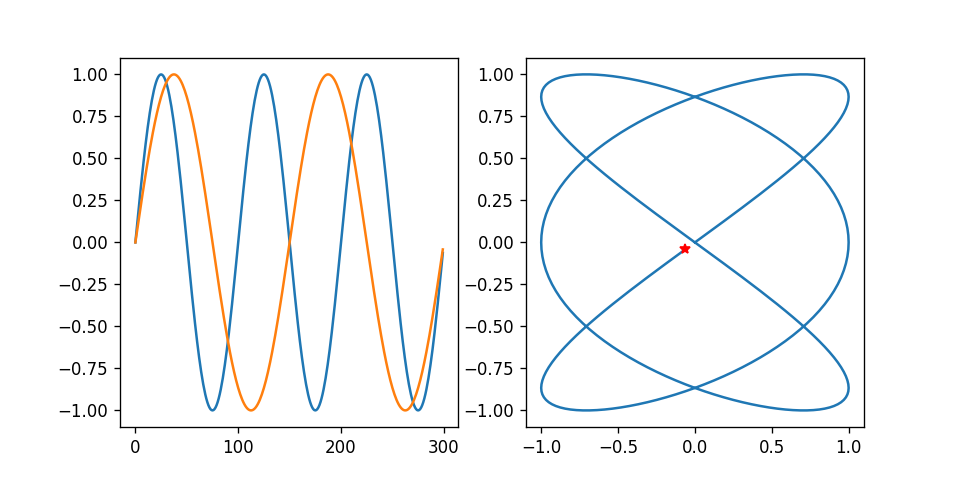

interactive(children=(FloatSlider(value=0.0, description='p', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [5]:
%matplotlib notebook
        
# Plot
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(t, x)
ax1.plot(t, y)

tp = timeplot(fig, ax2, np.array([x, y]), 0.5)
tp.interact()

<IPython.core.display.Javascript object>


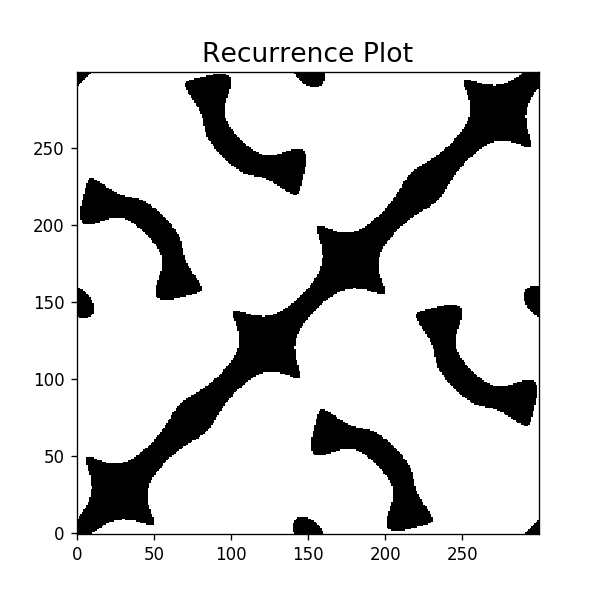

interactive(children=(IntSlider(value=50, description='w'), Output()), _dom_classes=('widget-interact',))

In [6]:
%matplotlib notebook
ip = interplot(np.array([x, y]), w0=0)
ip.interact()

In [7]:
def rhs_lorenz(v, s=10, r=28, b=2.667):
    x, y, z = v
    return np.array([s*(y - x), r*x - y - x*z, x*y - b*z])

def simulate_lorenz(dt=0.01, T=10):
    nStep = int(T / dt)

    vs = np.empty((nStep + 1, 3))
    vs[0] = np.array([0., 1., 1.05])

    for i in range(nStep):
        vs[i + 1] = vs[i] + rhs_lorenz(vs[i]) * dt
        
    return vs

<IPython.core.display.Javascript object>


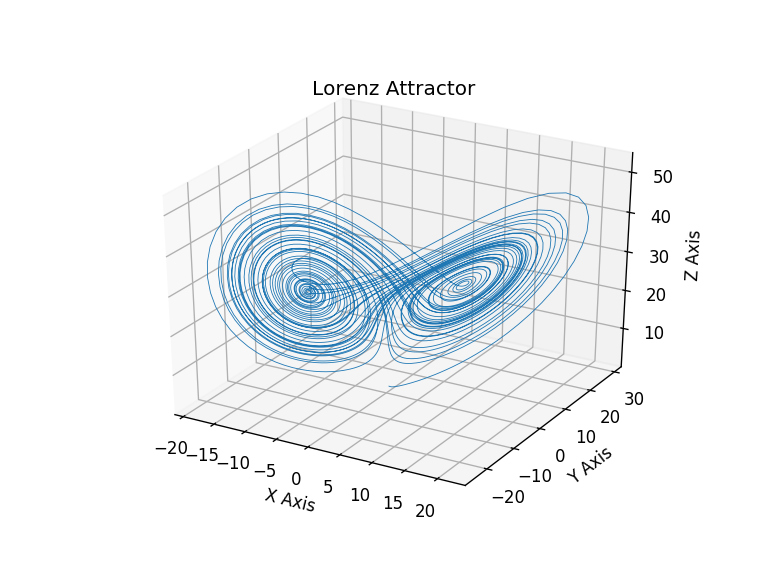

In [11]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
        
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

vs = simulate_lorenz(dt=0.01, T=50)
ax.plot(*vs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.savefig('lorenzAtt.png')
plt.show()

<IPython.core.display.Javascript object>


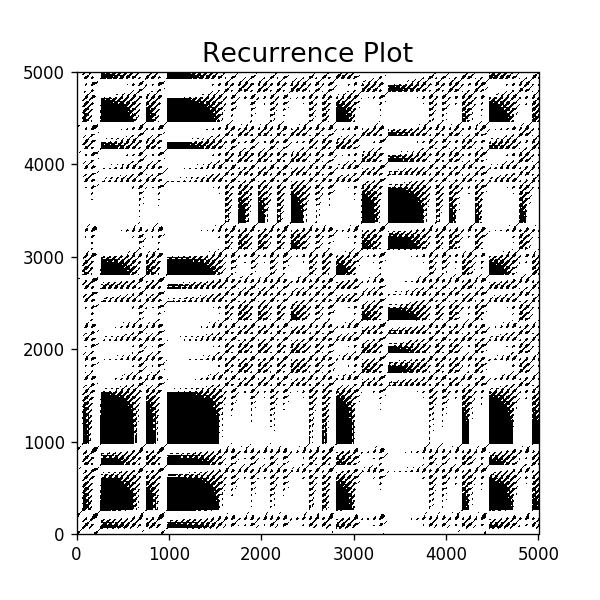

interactive(children=(IntSlider(value=50, description='w'), Output()), _dom_classes=('widget-interact',))

In [12]:
%matplotlib notebook
ip = interplot(vs.T, w0=0)
ip.interact()

In [10]:
plt.savefig('lorenz.png')

# PYTS

In [34]:
class interplotPYTS:    
    def __init__(self, data, u0, w0):
        self.u0 = u0
        self.w0 = w0
        self.nPoint, self.nTime = data.shape
        
        # Compute the recurrence plots with no threshold
        self.xrp = RecurrencePlot(threshold=None).transform(data)
        
        # Plot first
        picdata = self.get_plotdata(u0, w0)
        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.pic = self.ax.imshow(picdata, cmap='binary', origin='lower')
        self.ax.set_title('Recurrence Plot', fontsize=16)
    
    def get_plotdata(self, u, w):
        xrpThis = self.xrp[u]
        thr = np.percentile(xrpThis.flatten(), w)
        return xrpThis <= thr
    
    def update(self, u, w):
        picnew = self.get_plotdata(u, w)
        self.pic.set_data(picnew)
        self.fig.canvas.draw_idle()
        
    def interact(self):
        widgets.interact(self.update, u=(0, self.nPoint-1, 1), w=(0, 100, 1))

<IPython.core.display.Javascript object>


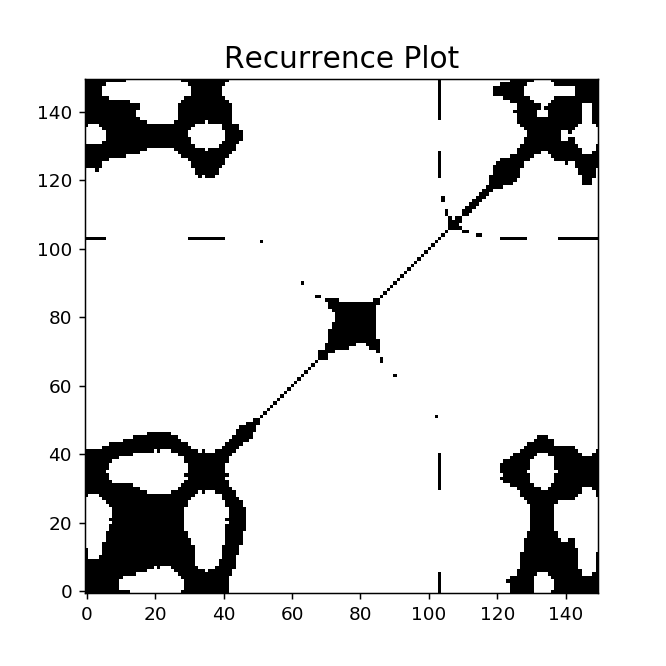

interactive(children=(IntSlider(value=24, description='u', max=49), IntSlider(value=50, description='w'), Outp…

In [35]:
data, _, _, _ = load_gunpoint(return_X_y=True)
ip = interplotPYTS(data, u0=0, w0=0)
ip.interact()

<IPython.core.display.Javascript object>


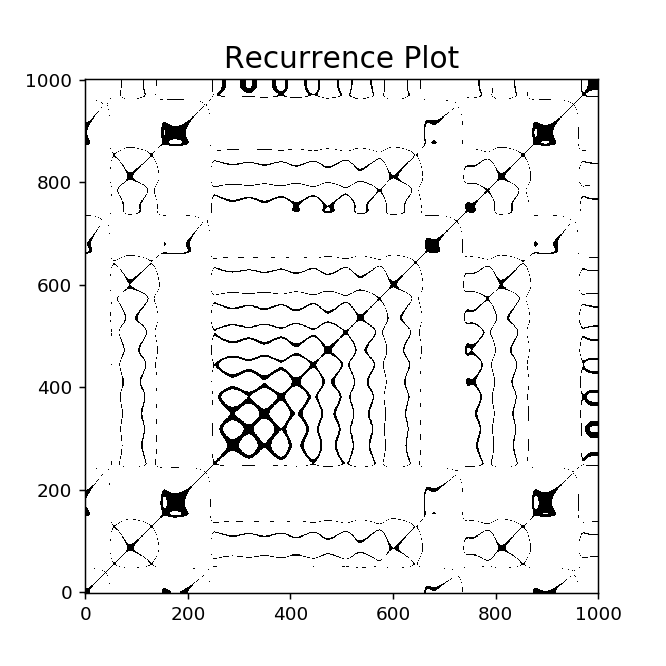

interactive(children=(IntSlider(value=1, description='u', max=2), IntSlider(value=50, description='w'), Output…

In [37]:
ip = interplotPYTS(np.array([xs, ys, zs]), u0=0, w0=0)
ip.interact()

<IPython.core.display.Javascript object>


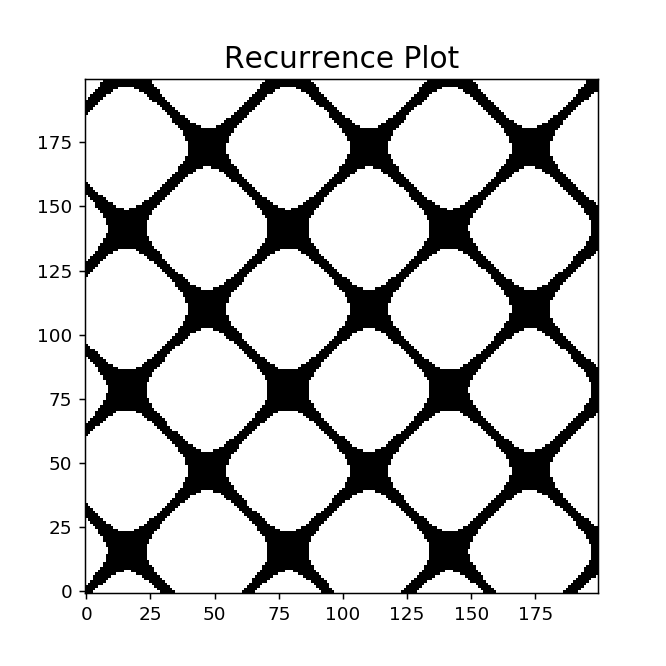

interactive(children=(IntSlider(value=1, description='u', max=2), IntSlider(value=50, description='w'), Output…

In [38]:
t = np.arange(200)
x = np.sin(t / 5)
y = np.sin(t / 10)
z = np.sin(t / 20)

ip = interplotPYTS(np.array([x, y, z]), u0=0, w0=0)
ip.interact()